In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import random
import time
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
import math
from imblearn.over_sampling import RandomOverSampler
import cv2

In [28]:
path = "../germany_dataset/train.csv"
df = pd.read_csv(path)
df = df.dropna()
filename="mobileNetV3"

In [29]:
df["length"] = df["Roi.X2"]-df["Roi.X1"]
df["height"] = df["Roi.Y2"]-df["Roi.Y1"]
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,length,height
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,17,15
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,18,16
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,18,16
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,18,16
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,18,16


In [30]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,length,height
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390,39.197786,38.765998
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238,21.821369,20.828697
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000,15.000000,15.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000,24.000000,24.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000,33.000000,32.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000,47.000000,47.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000,203.000000,185.000000


In [31]:
# All Variables declaration to use same code for different datasets
num_of_classes = df["ClassId"].nunique()
resize_x  = 32
resize_y  = 32
num_of_channels = 3
directory = "../germany_dataset/"
testdir = "../germany_dataset/test.csv"
Epochs=100
train_length = len(df)
Y_col_name="ClassId"

In [32]:
# Necessary Functions
def remove_outlier(df,parameter):
    Percentile25 = df[parameter].quantile(0.25)
    Percentile75 = df[parameter].quantile(0.75)
    iqr = Percentile75 - Percentile25
    lowerlimit = Percentile25 - 1.5*iqr
    upperlimit = Percentile75 + 1.5*iqr
    temp1 = df[parameter]>lowerlimit
    temp2 = df[parameter]<upperlimit
    return df[temp1 & temp2] 

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def viewStatistics(df):
    #Statistics of Data
    print("Total Training Examples : ",len(df))
    values = df["ClassId"].value_counts()
    x_labels = [str(x) for x in range(num_of_classes)]
    y_labels = []
    for x in range(num_of_classes):
        y_labels.append(values[x])
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels,y_labels,width=0.5)
    plt.title('Bar Graph')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = []
    for j in range(len(images)):
        img.append(np.array(images[j]))
    img = np.array(img)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

def PredictTest(model,df,start,length):
    images = []
    y_test = []
    length = min(length,len(df)-start)
    for i in range(length):
        row = df.loc[start+i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
    

    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

def PredictTest(model,df):
    images = []
    y_test = []
    length = len(df)
    for i in range(length):
        row = df.loc[i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
        
    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

Total Training Examples :  39209


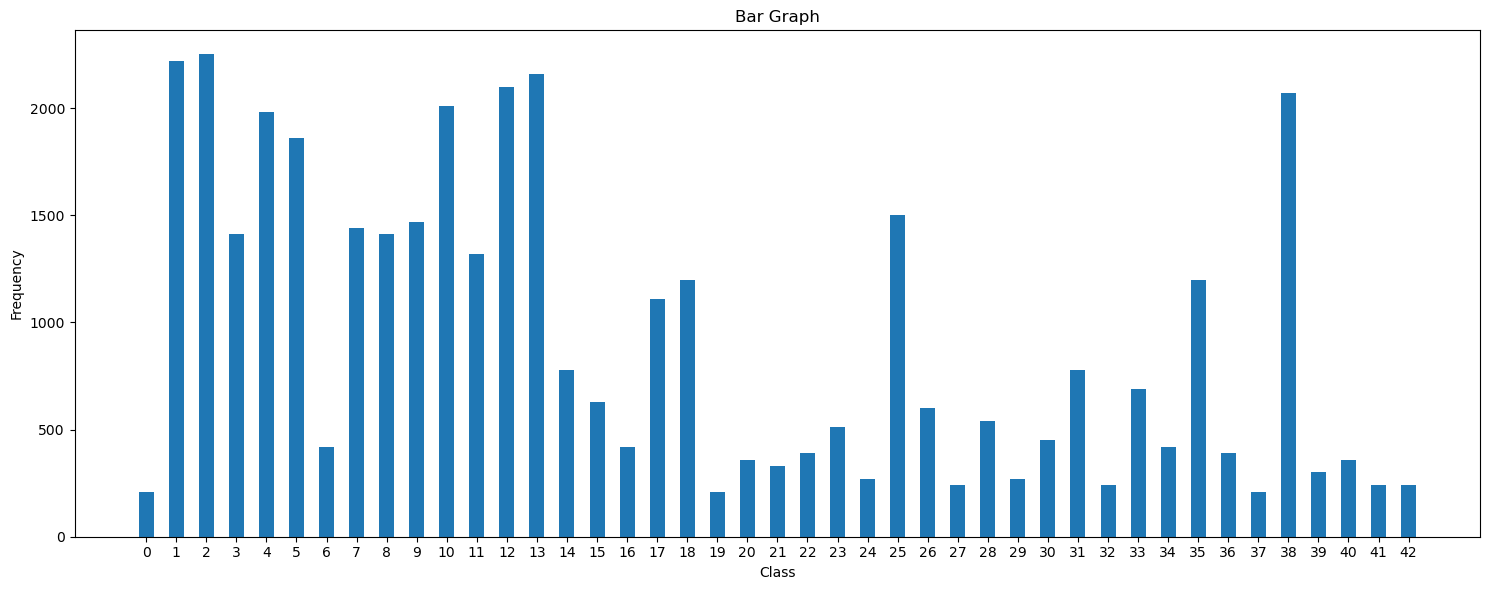

In [33]:
#Statistics of Data
viewStatistics(df)

In [34]:
train_length = len(df)
print("Total Training Examples : ",len(df))

Total Training Examples :  39209


In [35]:
# X = df.drop(Y_col_name, axis=1)
# y = df[Y_col_name]
# oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# # Fit and apply the oversampler to the data
# X_resampled, y_resampled = oversampler.fit_resample(X, y)

# df = pd.DataFrame(X_resampled, columns=X.columns)
# df[Y_col_name] = y_resampled
# df[Y_col_name].astype(str)

# viewStatistics(df)

In [36]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,length,height
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,17,15
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,18,16
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,18,16
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,18,16
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,18,16


In [37]:
# Sample Images and there crop according to data given in csv
def showExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer])
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val["Path"])
        ax.imshow(img)
        img = img.crop((val["Roi.X1"],val["Roi.Y1"],val["Roi.X2"],val["Roi.Y2"]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title("Class : "+ str(val["ClassId"]))
    ax.axis('off')

def showTestExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer])
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val["Path"])
        ax.imshow(img)
        img = img.crop((val["Roi.X1"],val["Roi.Y1"],val["Roi.X2"],val["Roi.Y2"]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title("Class : "+ str(val["ClassId"]))
    ax.axis('off')
    

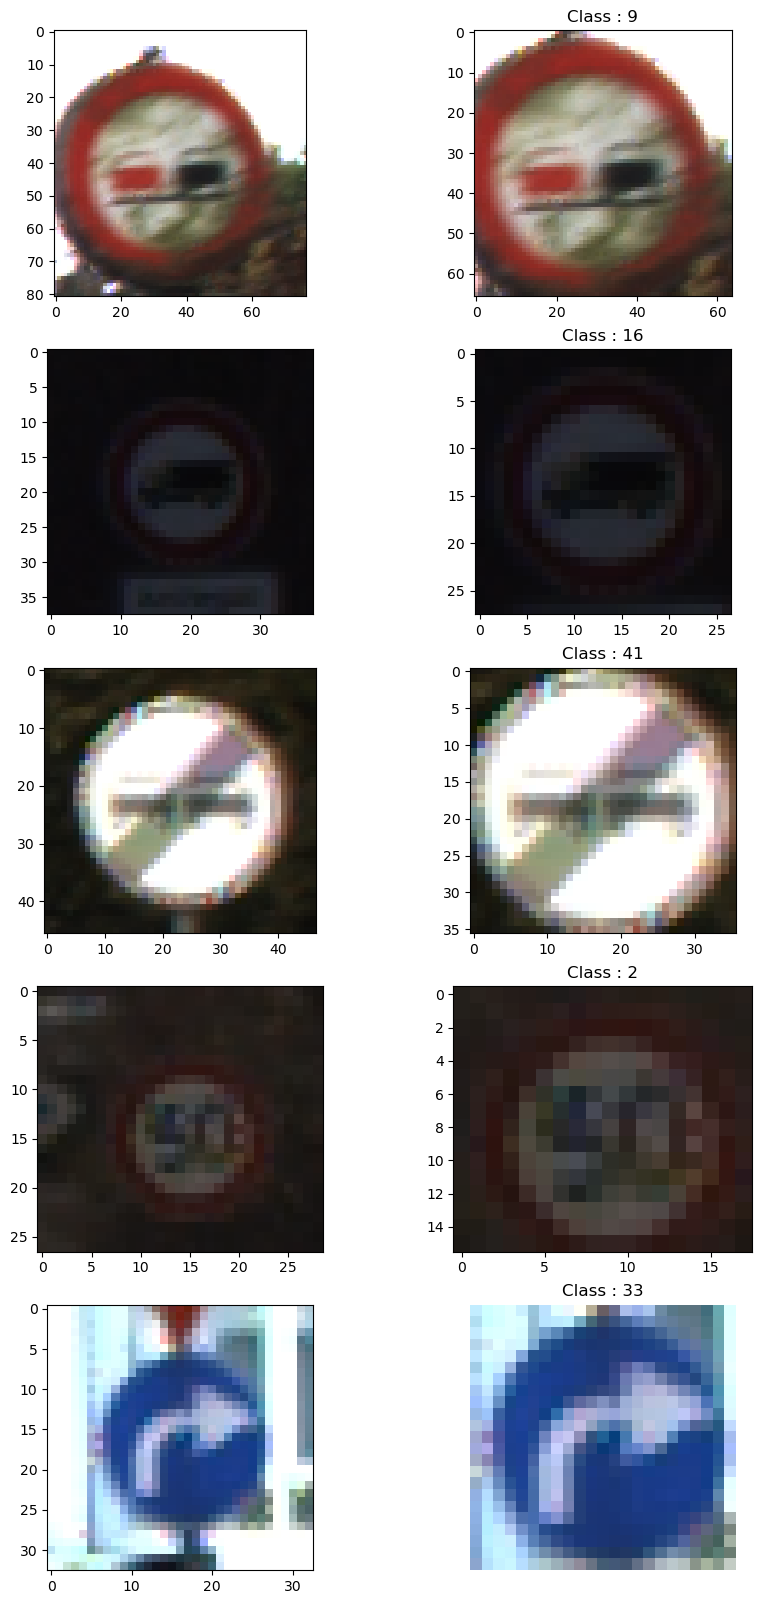

In [38]:
showExamples(df)

In [39]:
model = MobileNetV3Large(weights=None, input_shape=(resize_x, resize_y, 3), classes=num_of_classes)

# Display the model summary
model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 32, 32, 3)            0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 16, 16, 16)           432       ['rescaling_1[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 16, 16, 16)           64        ['Conv[0][0]']                
 lization)                                                                         

                                                                                                  
 expanded_conv_2/depthwise   (None, 8, 8, 72)             648       ['re_lu_44[0][0]']            
 (DepthwiseConv2D)                                                                                
                                                                                                  
 expanded_conv_2/depthwise/  (None, 8, 8, 72)             288       ['expanded_conv_2/depthwise[0]
 BatchNorm (BatchNormalizat                                         [0]']                         
 ion)                                                                                             
                                                                                                  
 re_lu_45 (ReLU)             (None, 8, 8, 72)             0         ['expanded_conv_2/depthwise/Ba
                                                                    tchNorm[0][0]']               
          

 )                                                                                                
                                                                                                  
 re_lu_49 (ReLU)             (None, 4, 4, 120)            0         ['expanded_conv_4/expand/Batch
                                                                    Norm[0][0]']                  
                                                                                                  
 expanded_conv_4/depthwise   (None, 4, 4, 120)            3000      ['re_lu_49[0][0]']            
 (DepthwiseConv2D)                                                                                
                                                                                                  
 expanded_conv_4/depthwise/  (None, 4, 4, 120)            480       ['expanded_conv_4/depthwise[0]
 BatchNorm (BatchNormalizat                                         [0]']                         
 ion)     

 cite/Conv_1 (Conv2D)                                               te/Relu[0][0]']               
                                                                                                  
 tf.__operators__.add_32 (T  (None, 1, 1, 120)            0         ['expanded_conv_5/squeeze_exci
 FOpLambda)                                                         te/Conv_1[0][0]']             
                                                                                                  
 re_lu_54 (ReLU)             (None, 1, 1, 120)            0         ['tf.__operators__.add_32[0][0
                                                                    ]']                           
                                                                                                  
 tf.math.multiply_32 (TFOpL  (None, 1, 1, 120)            0         ['re_lu_54[0][0]']            
 ambda)                                                                                           
          

 FOpLambda)                                                         Norm[0][0]']                  
                                                                                                  
 re_lu_57 (ReLU)             (None, 2, 2, 200)            0         ['tf.__operators__.add_35[0][0
                                                                    ]']                           
                                                                                                  
 tf.math.multiply_35 (TFOpL  (None, 2, 2, 200)            0         ['re_lu_57[0][0]']            
 ambda)                                                                                           
                                                                                                  
 multiply_24 (Multiply)      (None, 2, 2, 200)            0         ['expanded_conv_7/expand/Batch
                                                                    Norm[0][0]',                  
          

                                                                                                  
 expanded_conv_8/project (C  (None, 2, 2, 80)             14720     ['multiply_27[0][0]']         
 onv2D)                                                                                           
                                                                                                  
 expanded_conv_8/project/Ba  (None, 2, 2, 80)             320       ['expanded_conv_8/project[0][0
 tchNorm (BatchNormalizatio                                         ]']                           
 n)                                                                                               
                                                                                                  
 expanded_conv_8/Add (Add)   (None, 2, 2, 80)             0         ['expanded_conv_7/Add[0][0]', 
                                                                     'expanded_conv_8/project/Batc
          

 expanded_conv_10/depthwise  (None, 2, 2, 480)            4320      ['multiply_30[0][0]']         
  (DepthwiseConv2D)                                                                               
                                                                                                  
 expanded_conv_10/depthwise  (None, 2, 2, 480)            1920      ['expanded_conv_10/depthwise[0
 /BatchNorm (BatchNormaliza                                         ][0]']                        
 tion)                                                                                            
                                                                                                  
 tf.__operators__.add_42 (T  (None, 2, 2, 480)            0         ['expanded_conv_10/depthwise/B
 FOpLambda)                                                         atchNorm[0][0]']              
                                                                                                  
 re_lu_64 

                                                                    ]']                           
                                                                                                  
 tf.math.multiply_45 (TFOpL  (None, 2, 2, 672)            0         ['re_lu_67[0][0]']            
 ambda)                                                                                           
                                                                                                  
 multiply_33 (Multiply)      (None, 2, 2, 672)            0         ['expanded_conv_11/depthwise/B
                                                                    atchNorm[0][0]',              
                                                                     'tf.math.multiply_45[0][0]'] 
                                                                                                  
 expanded_conv_11/squeeze_e  (None, 1, 1, 672)            0         ['multiply_33[0][0]']         
 xcite/Avg

 ambda)                                                                                           
                                                                                                  
 multiply_35 (Multiply)      (None, 1, 1, 672)            0         ['expanded_conv_12/depthwise/B
                                                                    atchNorm[0][0]',              
                                                                     'tf.math.multiply_48[0][0]'] 
                                                                                                  
 expanded_conv_12/squeeze_e  (None, 1, 1, 672)            0         ['multiply_35[0][0]']         
 xcite/AvgPool (GlobalAvera                                                                       
 gePooling2D)                                                                                     
                                                                                                  
 expanded_

 xcite/Conv (Conv2D)                                                ite/AvgPool[0][0]']           
                                                                                                  
 expanded_conv_13/squeeze_e  (None, 1, 1, 240)            0         ['expanded_conv_13/squeeze_exc
 xcite/Relu (ReLU)                                                  ite/Conv[0][0]']              
                                                                                                  
 expanded_conv_13/squeeze_e  (None, 1, 1, 960)            231360    ['expanded_conv_13/squeeze_exc
 xcite/Conv_1 (Conv2D)                                              ite/Relu[0][0]']              
                                                                                                  
 tf.__operators__.add_52 (T  (None, 1, 1, 960)            0         ['expanded_conv_13/squeeze_exc
 FOpLambda)                                                         ite/Conv_1[0][0]']            
          

 xcite/Conv_1 (Conv2D)                                              ite/Relu[0][0]']              
                                                                                                  
 tf.__operators__.add_55 (T  (None, 1, 1, 960)            0         ['expanded_conv_14/squeeze_exc
 FOpLambda)                                                         ite/Conv_1[0][0]']            
                                                                                                  
 re_lu_77 (ReLU)             (None, 1, 1, 960)            0         ['tf.__operators__.add_55[0][0
                                                                    ]']                           
                                                                                                  
 tf.math.multiply_55 (TFOpL  (None, 1, 1, 960)            0         ['re_lu_77[0][0]']            
 ambda)                                                                                           
          

In [40]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
print(df["ClassId"].dtype)
# df["ClassId"] = df["ClassId"].astype(str)
# print(df["ClassId"].dtype)

int64


In [42]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,length,height
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,17,15
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,18,16
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,18,16
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,18,16
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,18,16


In [43]:
class Data:
    def __init__(self,df,size_x,size_y):
        self.df = df
        self.root = directory
        self.resize_x = size_x
        self.resize_y = size_y
    
    def resize_and_center(self,image, target_height, target_width):
        original_height, original_width= image.size
        height_ratio = target_height / original_height
        width_ratio = target_width / original_width
        resize_ratio = min(height_ratio, width_ratio)
        new_height = int(original_height * resize_ratio)
        new_width = int(original_width * resize_ratio)
        image  = np.array(image)
        resized_image = cv2.resize(image, (new_width, new_height))
        pad_height = max(0, (target_height - new_height) // 2)
        pad_width = max(0, (target_width - new_width) // 2)
        centered_image = cv2.copyMakeBorder(resized_image, pad_height, target_height - new_height - pad_height,pad_width, target_width - new_width - pad_width,cv2.BORDER_CONSTANT, value=(255, 255, 255))
        return centered_image

    def Do_Crop(self,path,x1,y1,x2,y2):
        img = Image.open(self.root+path)
        img = img.crop((x1,y1,x2,y2))
        img = img.resize((resize_x,resize_y))
        img = np.array(img,dtype=float)
        img = img/255.0
        return img
    
    def Row_Data(self,row):
        img = self.Do_Crop(row["Path"],row["Roi.X1"],row["Roi.Y1"],row["Roi.X2"],row["Roi.Y2"])
        self.X.append(img)
        self.Y.append(int(row["ClassId"]))
        
    def Get_Data(self):
        self.X = []
        self.Y = []
        for i in range(len(self.df)):
            row = self.df.iloc[i]
            self.Row_Data(row)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y,dtype=int)

In [ ]:
def miniDataTrain(model,df,train_split):
    data = Data(df,resize_x,resize_y)
    data.Get_Data()
    X_train = data.X
    Y_train = []
    for val in data.Y:
        x = [0]*num_of_classes
        x[val]=1
        x = np.array(x)
        Y_train.append(x)
    Y_train = np.array(Y_train)
#     for i,v in enumerate(X_train):
#         print(data.Y[i])
#         plt.imshow(v)
#         plt.show()
    history = model.fit(X_train,Y_train,epochs=1,batch_size=len(X_train),validation_split=1-train_split,verbose=0)
    training_accuracy = history.history['accuracy'][0]
    validation_accuracy = history.history['val_accuracy'][0]
    loss = history.history['loss'][0]
    val_loss = history.history['val_loss'][0]
    return [training_accuracy,validation_accuracy,loss,val_loss]    

def SingleEpochTrain(model,df,batchsize=256,train_split=0.8):
    num_train = len(df)
    df = df.sample(frac=1)
    num_mini_trains = math.ceil(num_train/batchsize)
    training_accuracy = 0
    validation_accuracy = 0
    loss = 0
    val_loss = 0
    starting_time = time.time()
    for i in range(num_mini_trains):      
        if(num_mini_trains == i+1):
            presentBatchSize = num_train - i*batchsize
        else :
            presentBatchSize = batchsize      
        df1 = df.iloc[i*batchsize:i*batchsize+presentBatchSize,:]
        params = miniDataTrain(model,df1,train_split)
        training_accuracy += presentBatchSize*params[0]
        validation_accuracy+= presentBatchSize*params[1]
        loss += params[2]
        val_loss += params[3]
    training_accuracy/=(num_train)
    validation_accuracy/=(num_train)
    ending_time = time.time()
    total_time = ending_time - starting_time
    total_time/=60
    print("Accuracy: ",training_accuracy," Val Accuracy: ",validation_accuracy," Trained for ",total_time," min")
    return [training_accuracy,validation_accuracy,loss,val_loss];

In [ ]:
start_time   = time.time()

training_accuracy = []
validation_accuracy = []
loss = []
val_loss = []

for i in range(Epochs):
    print("Epoch : ", i)
    params = SingleEpochTrain(model,df)
    training_accuracy.append(params[0])
    validation_accuracy.append(params[1])
    loss.append(params[2])
    val_loss.append(params[3])

end_time = time.time()
print("Time taken : ", (end_time - start_time)/60," min")

Epoch :  0
       Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
22749     45      46       5       6      39      40       14   
5831      32      31       5       5      26      26        3   
16213     35      35       5       5      30      30       10   
37359     30      32       5       5      25      27       38   
20881     45      40       6       5      39      35       13   

                                 Path  length  height  
22749  Train/14/00014_00004_00009.png      34      34  
5831    Train/3/00003_00026_00011.png      21      21  
16213  Train/10/00010_00039_00013.png      25      25  
37359  Train/38/00038_00045_00010.png      20      22  
20881  Train/13/00013_00014_00001.png      33      30  
Accuracy:  0.9642498994427549  Val Accuracy:  0.04771275165089598  Trained for  3.0553677360216778  min
Epoch :  1
       Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
28086     45      42       5       5      40      37       23   
17775     45     

In [ ]:
#Saving the model
model.save(filename)

In [ ]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,training_accuracy,color="blue",label="Training Accuracy")
plt.plot(epochs,validation_accuracy,color="red",label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color="blue",label="training loss")
plt.plot(epochs,val_loss,color="red",label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

 ***Test Image Classification and Accuracy Calculation***

In [ ]:
#Loading weights into CNN model 
# model = tf.keras.models.load_model("filename")

In [ ]:
df_test = pd.read_csv(testdir)
df_test["ClassId"] =df_test["ClassId"].astype(str)
print("Number of Test Images are ", len(df_test))
df_test.dropna()
df_test.head()

In [ ]:
viewStatistics(df_test)

In [ ]:
df_test.head()

In [ ]:
showTestExamples(df_test)

In [ ]:
# X = df_test.drop(Y_col_name, axis=1)
# y = df_test[Y_col_name]
# oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# # Fit and apply the oversampler to the data
# X_resampled, y_resampled = oversampler.fit_resample(X, y)

# df_test = pd.DataFrame(X_resampled, columns=X.columns)
# df_test[Y_col_name] = y_resampled
# df_test[Y_col_name] = df_test[Y_col_name].astype(str)

In [ ]:
df_test.head()

In [ ]:
test_images = []
data = Data(df_test,resize_x,resize_y)
data.Get_Data()
X_test  = data.X
y_test = data.Y

In [ ]:
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
print(y_pred)
print(y_test)

In [ ]:
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy*100)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
print("\n\n\n Summarizing the results : ")
report

In [ ]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()